In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [4]:


df = pd.read_csv('/kaggle/input/onion/onion_price_2012_to_2024_cleaned.csv')
# Data Preprocessing
# Convert 'Price Date' to datetime
df['Price Date'] = pd.to_datetime(df['Price Date'], errors='coerce')
df.dropna(subset=['Price Date'], inplace=True)

# Extract Year, Month, Day
df['Year'] = df['Price Date'].dt.year
df['Month'] = df['Price Date'].dt.month
df['Day'] = df['Price Date'].dt.day

# Calculate average price
df['Average Price'] = (df['Min Price (Rs./Quintal)'] + df['Max Price (Rs./Quintal)'] + df['Modal Price (Rs./Quintal)']) / 3

# Categorize the average price into 'Low', 'Mid', 'High'
df['Price Category'] = pd.cut(df['Average Price'], bins=[0, 1000, 2000, float('inf')], labels=['Low', 'Mid', 'High'])

# Features and Target
X = df[['Year', 'Month', 'Day']]
y = df['Price Category']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


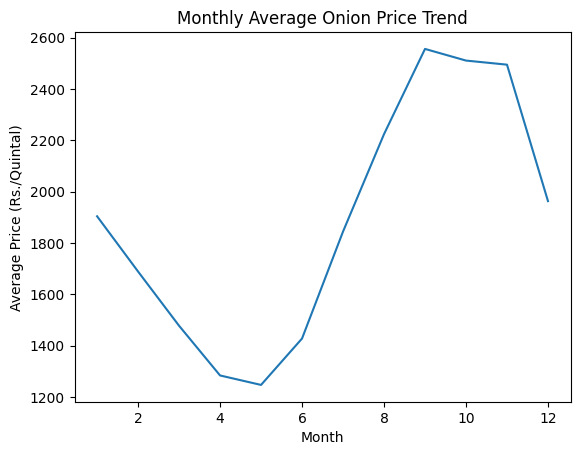

In [5]:
# 2. Monthly price trend
monthly_avg = df.groupby('Month', observed=False)['Average Price'].mean()
plt.plot(monthly_avg)
plt.title('Monthly Average Onion Price Trend')
plt.xlabel('Month')
plt.ylabel('Average Price (Rs./Quintal)')
plt.show()

In [6]:
# Extra: LSTM Model
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse')
    return model

# Reshape data for LSTM
X_lstm = df[['Average Price']].values
scaler_lstm = StandardScaler()
X_lstm = scaler_lstm.fit_transform(X_lstm)

# Create dataset for LSTM
def create_dataset(X, time_step=1):
    Xs, ys = [], []
    for i in range(len(X) - time_step - 1):
        Xs.append(X[i:(i + time_step), 0])
        ys.append(X[i + time_step, 0])
    return np.array(Xs), np.array(ys)

time_step = 10
X_lstm, y_lstm = create_dataset(X_lstm, time_step)
X_lstm = X_lstm.reshape(X_lstm.shape[0], X_lstm.shape[1], 1)

# Split data
train_size = int(len(X_lstm) * 0.7)
X_train_lstm, X_test_lstm = X_lstm[:train_size], X_lstm[train_size:]
y_train_lstm, y_test_lstm = y_lstm[:train_size], y_lstm[train_size:]

# Train LSTM Model
lstm_model = create_lstm_model((X_train_lstm.shape[1], 1))
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=1, batch_size=1, verbose=1)
lstm_predictions = lstm_model.predict(X_test_lstm)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1044795/1044795 ━━━━━━━━━━━━━━━━━━━━ 6476s 6ms/step - loss: 0.3073
13993/13993 ━━━━━━━━━━━━━━━━━━━━ 69s 5ms/step


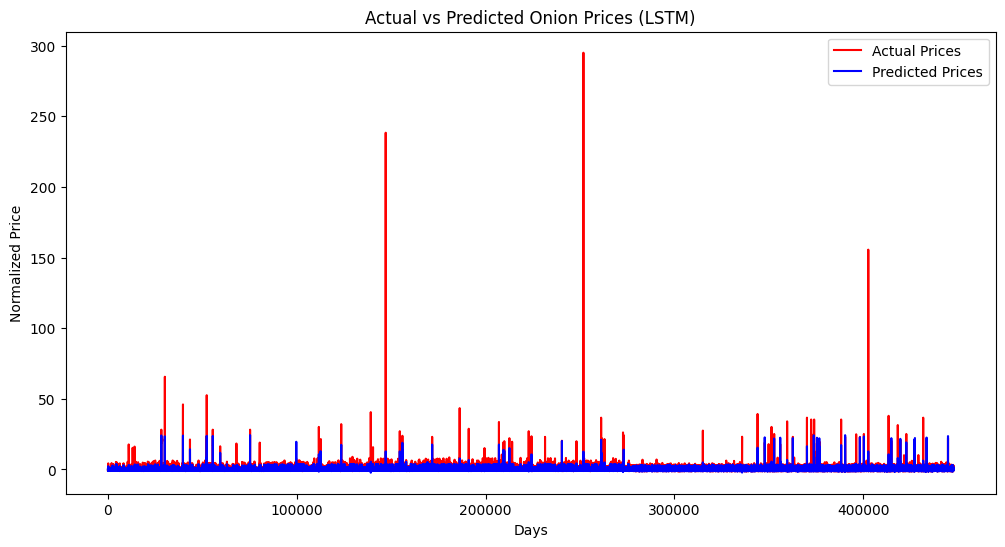

In [7]:
 #Actual vs Predicted Prices (LSTM)
plt.figure(figsize=(12, 6))
plt.plot(y_test_lstm, label='Actual Prices', color='red')
plt.plot(lstm_predictions, label='Predicted Prices', color='blue')
plt.title('Actual vs Predicted Onion Prices (LSTM)')
plt.xlabel('Days')
plt.ylabel('Normalized Price')
plt.legend()
plt.show()